In [21]:
import re
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
# Beispiel-Logdatei (ersetze mit Pfad zu deiner Datei)
log_files = [
                "I:/dataset/runs/train_ddcolor_l_run_old_256_10k_200klong/train_train_ddcolor_l_run_old_256_10k_long_20250707_173830.log",
                "I:/dataset/runs/train_ddcolor_l_run_modern_256_8k_200klong/train_train_ddcolor_l_run_modern_256_8k_200klong_20250708_013548.log",
                "I:/dataset/runs/train_ddcolor_l_run_old_256_12k_sq4_200klong/train_train_ddcolor_l_run_old_256_12k_sq4_200klong_20250709_160103.log",
            ]
output_paths = [
                    "I:/dataset/runs/train_ddcolor_l_run_old_256_10k_200klong",
                    "I:/dataset/runs/train_ddcolor_l_run_modern_256_8k_200klong",
                    "I:/dataset/runs/train_ddcolor_l_run_old_256_12k_sq4_200klong",
                ]
# Regex-Muster
train_pattern = re.compile(
    r"iter:\s*([\d,]+),.*?eta:\s*([\d:]+),.*?"
    r"l_g_pix:\s*([\deE\+\.-]+)\s*"
    r"l_g_percep:\s*([\deE\+\.-]+)\s*"
    r"l_g_gan:\s*([\deE\+\.-]+)\s*"
    r"l_g_color:\s*([\deE\+\.-]+)\s*"
    r"l_d:\s*([\deE\+\.-]+)\s*"
    r"real_score:\s*([\deE\+\.-]+)\s*"
    r"fake_score:\s*([\deE\+\.-]+)"
)

fid_pattern = re.compile(r"# fid:\s*([\d\.]+)\s*Best:\s*([\d\.]+)\s*@\s*(\d+)")
cf_pattern = re.compile(r"# cf:\s*([\d\.]+)\s*Best:\s*([\d\.]+)\s*@\s*(\d+)")

In [23]:
for log_file, output_path in zip(log_files, output_paths):
    # Ergebnislisten
    train_data = []

    with open(log_file, 'r') as f:
        for line in f:
            train_match = train_pattern.search(line)
            if train_match:
                iter_, eta, l_pix, l_per, l_gan, l_color, l_d, r_score, f_score = train_match.groups()
                train_data.append({
                    'iter': int(iter_.replace(',', '')),  # <-- wichtig!
                    'eta': eta,
                    'l_g_pix': float(l_pix),
                    'l_g_percep': float(l_per),
                    'l_g_gan': float(l_gan),
                    'l_g_color': float(l_color),
                    'l_d': float(l_d),
                    'real_score': float(r_score),
                    'fake_score': float(f_score)
                })

    # DataFrames erstellen
    df_train = pd.DataFrame(train_data)
    df_train.to_csv(output_path + "/train_data.csv", index=False)

In [24]:

for log_file, output_path in zip(log_files, output_paths):
    awaiting_fid = False
    current_fid = {}
    val_data = []

    with open(log_file, 'r') as f:
        for line in f:
            line = line.strip()

            if "Validation ImageNet" in line:
                awaiting_fid = True
                continue

            if awaiting_fid and line.startswith("# fid:"):
                match = fid_pattern.search(line)
                if match:
                    fid, fid_best, fid_best_iter = match.groups()
                    current_fid['fid'] = float(fid)
                    current_fid['fid_best'] = float(fid_best)
                    current_fid['fid_best_iter'] = int(fid_best_iter)

            if awaiting_fid and line.startswith("# cf:"):
                match = cf_pattern.search(line)
                if match:
                    cf, cf_best, cf_best_iter = match.groups()
                    current_fid['cf'] = float(cf)
                    current_fid['cf_best'] = float(cf_best)
                    current_fid['cf_best_iter'] = int(cf_best_iter)
                    current_fid['iter'] = current_fid['fid_best_iter']
                    val_data.append(current_fid)
                    current_fid = {}
                    awaiting_fid = False

    df_val = pd.DataFrame(val_data)
    df_val.to_csv(output_path + "/val_data.csv", index=False)

In [25]:

# === CONFIGURABLE SECTION ===

# List of CSV files (paths or filenames)
csv_files = [
    "I:/dataset/runs/train_ddcolor_l_run_modern_512_20k_noOutline_long/train_data.csv",
    "I:/dataset/runs/train_ddcolor_l_run_modern_256_8k_200klong/train_data.csv",
    "I:/dataset/runs/train_ddcolor_l_run_old_256_10k_200klong/train_data.csv",
    "I:/dataset/runs/train_ddcolor_l_run_old_256_12k_sq4_200klong/train_data.csv"

]

# Names to use for each run (must match length of csv_files)
labels = [
    "train_ddcolor_l_run_modern_512_20k_long",
    "train_ddcolor_l_run_modern_256_8k_200klong",
    "train_ddcolor_l_run_old_256_10k_200klong",
    "train_ddcolor_l_run_old_256_12k_sq4_200klong"
]

# Metrics to compare
#'l_g_pix':      "Pixel Loss (low = better)",
#'l_g_percep':   "Perceptual Loss (low = better)",
#'l_g_gan':      "GAN Loss (low = better)",
#'l_g_color':    "Color Loss (low = better)",
#'l_d':          "Discriminator Loss (low = better)",
#'real_score':   "Real Score (high = better)",
#'fake_score':   "Fake Score (low = better)",
#'fid':          "FID (low = better)",
#'cf':           "CF (higher = better)",
metrics = {
    'l_g_pix':       "Pixel Loss (low = better)",
    'l_g_percep':    "Perceptual Loss (low = better)",
    'l_g_gan':       "GAN Loss (low = better)",
    'l_g_color':     "Color Loss (low = better)",
    'l_d':           "Discriminator Loss (lower = better)",
    'real_score':    "Real Score (to 0 = better)",
    'fake_score':    "Fake Score (to 0 = better)",
}


In [26]:
# Load all CSVs into DataFrames
dataframes = [pd.read_csv(csv) for csv in csv_files]


# Load and downsample all CSVs (keeping only every 1000th iteration)
dataframes = [
    pd.read_csv(csv).astype({'iter': int})  # ensures 'iter' is numeric
    .query('iter % 1000 == 0')              # or use .loc[df['iter'] % 1000 == 0]
    for csv in csv_files
]

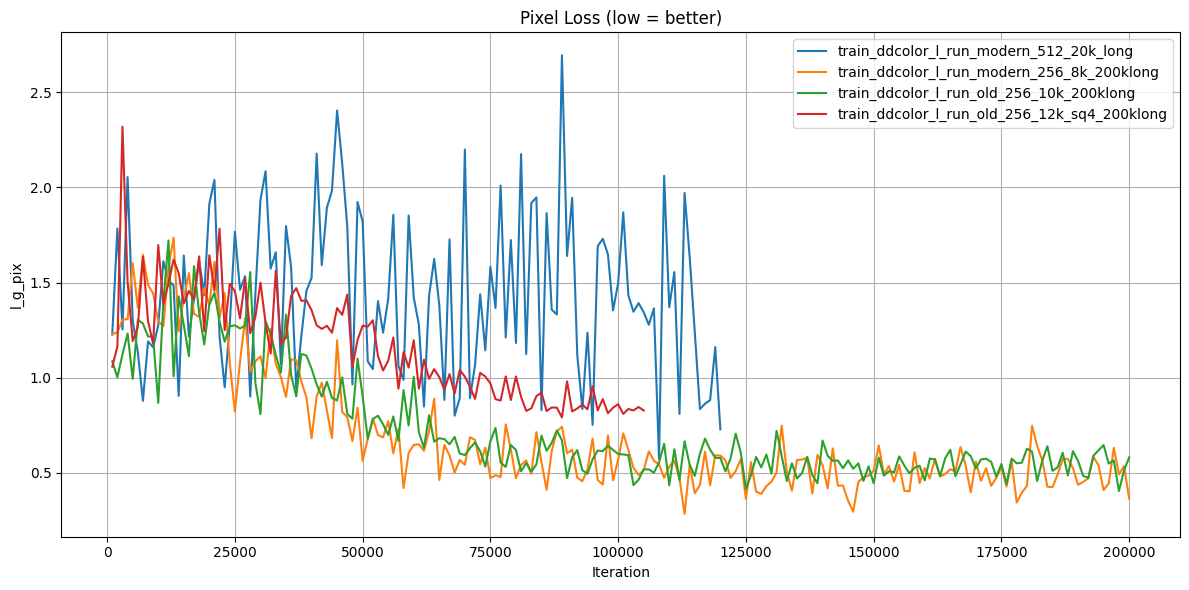

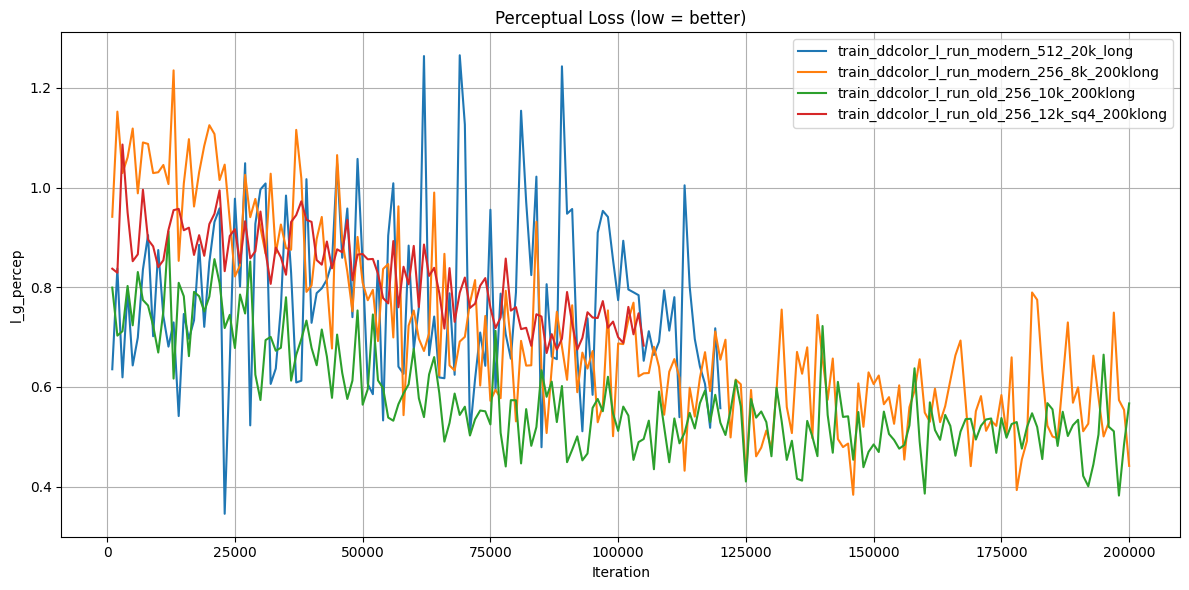

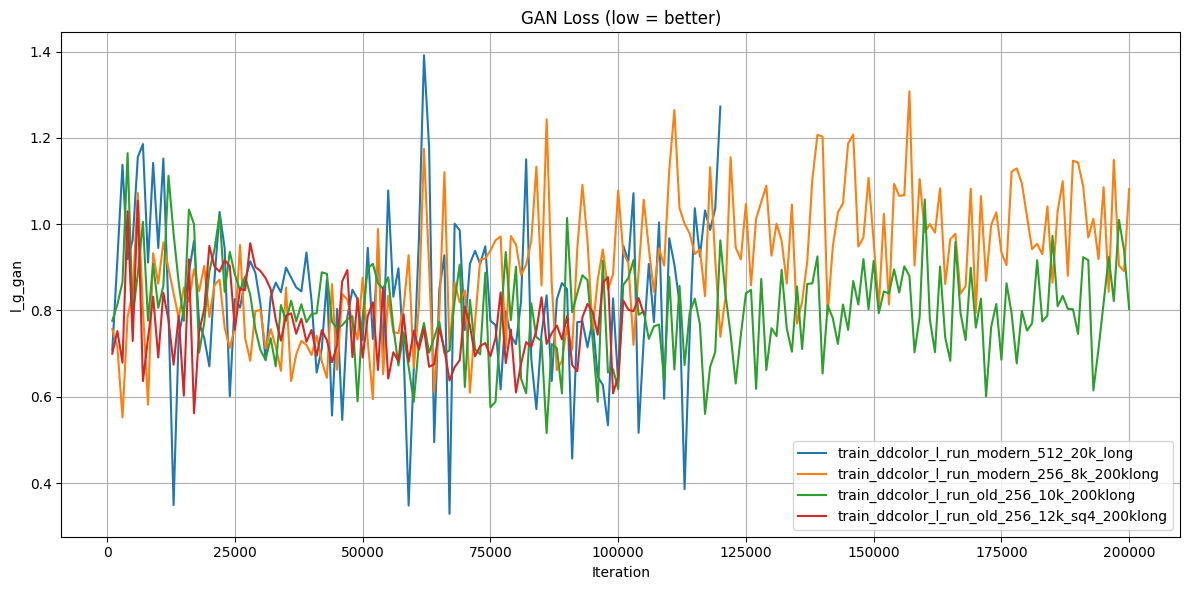

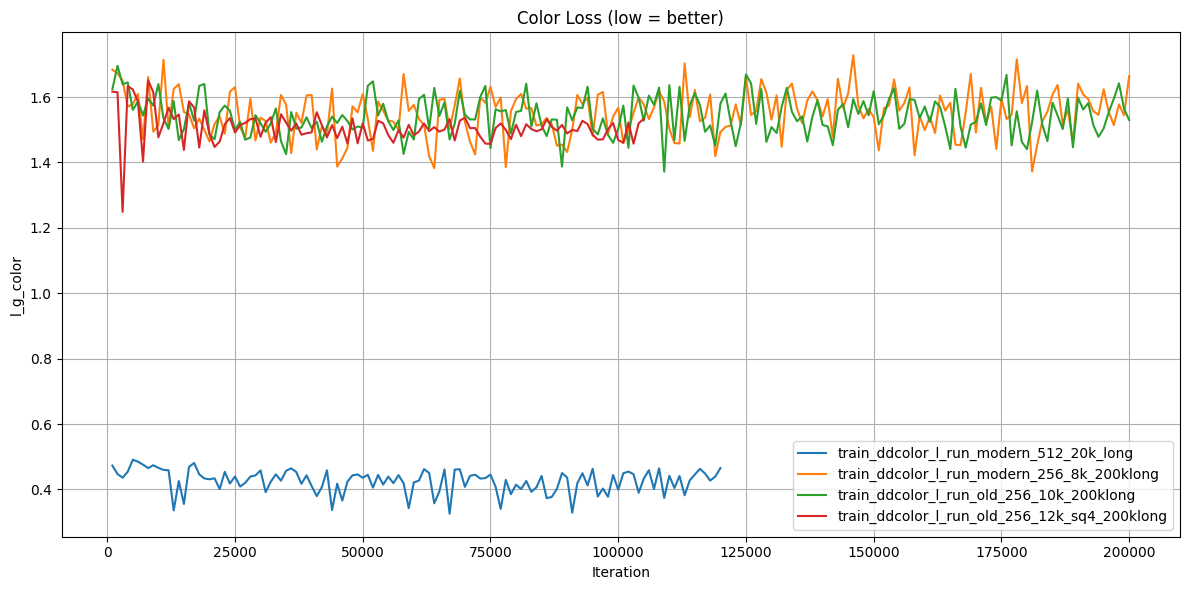

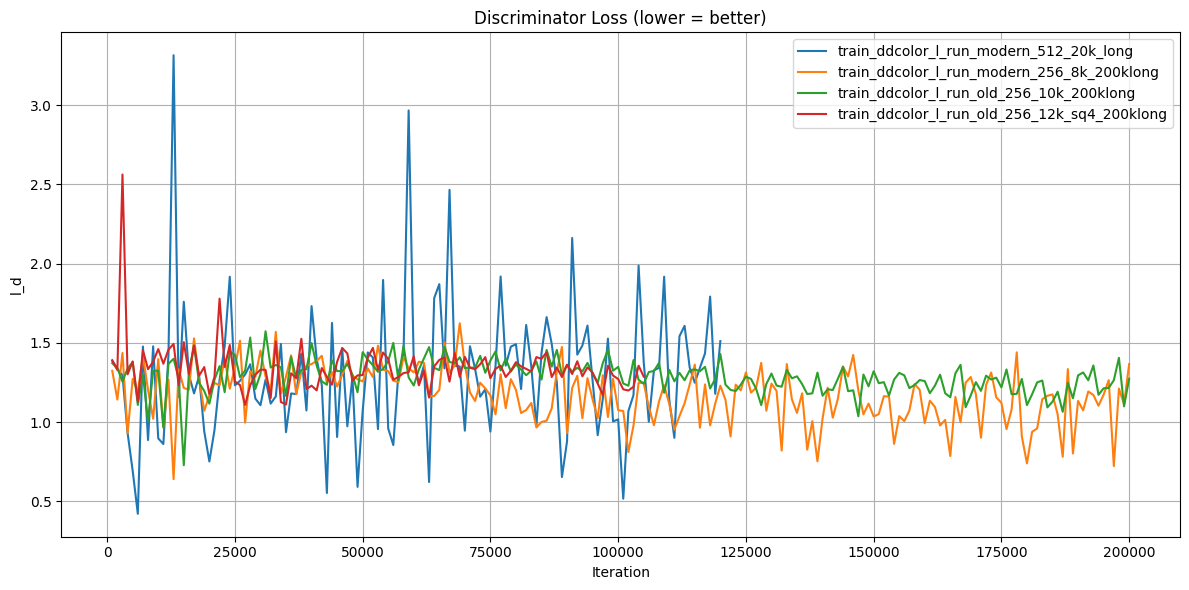

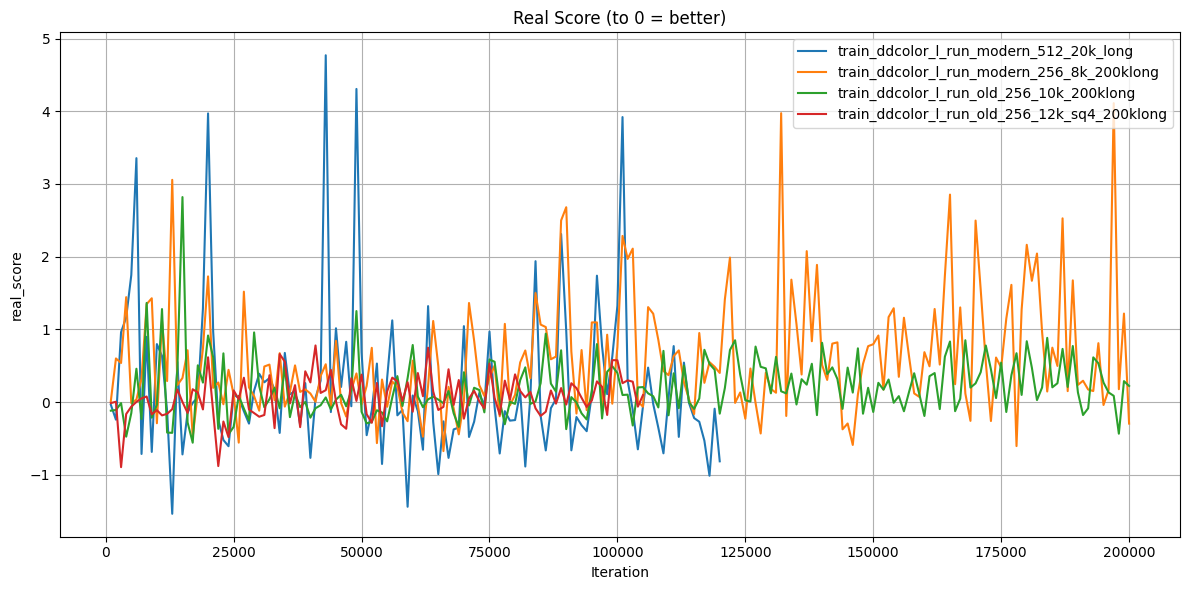

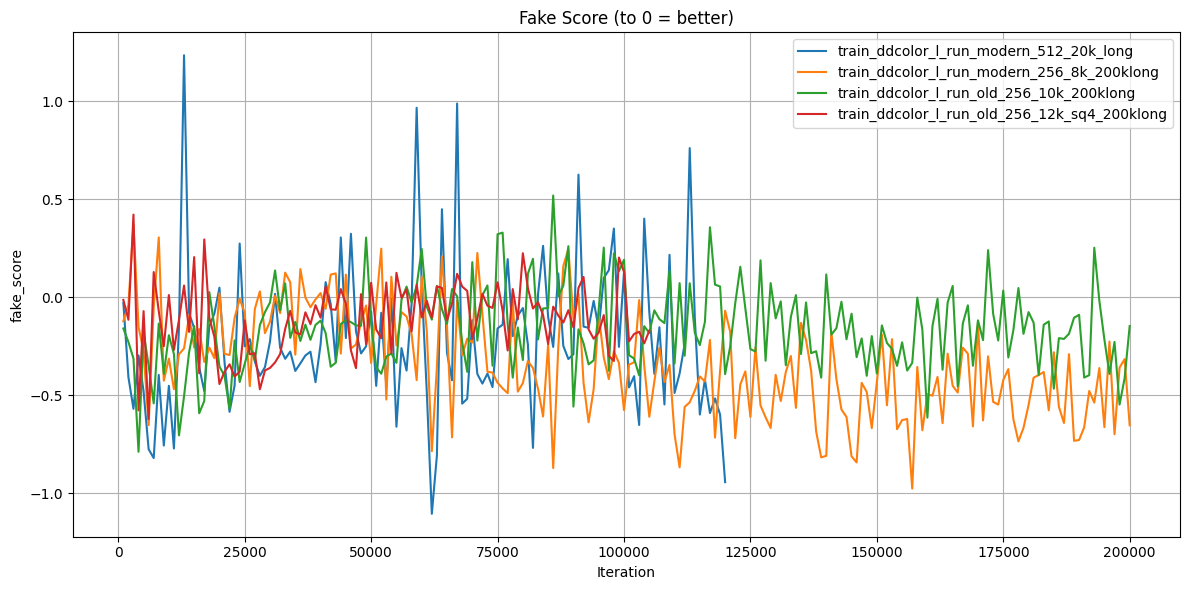

In [27]:
# === LOAD & PLOT ===

# Iterate over metrics and plot each in a separate subplot
for metric, metric_label in metrics.items():
    plt.figure(figsize=(12, 6))
    for df, label in zip(dataframes, labels):
        if metric in df.columns:
            plt.plot(df['iter'], df[metric], label=label)
    plt.title(f"{metric_label}")
    plt.xlabel("Iteration")
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()